In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_5_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D
import math

Caricamento file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models_atmos_new.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
    list_4_clusters_new = dill.load(file)

In [3]:
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

GS con la nuova clusterizzazione a 6 cluster

Gulf stream

In [4]:
#Gulf stream box della climatologia per tutti i modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #dataset nel box gulf stream
    models[name]['GS box'] = models[name]['North Atlantic box'].sel(time=slice("1982-01","2014-12"),lon=slice(282,310),lat=slice(29,50))
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        if (i+1) == 4 : #DJF
            models[name]['tos North Atlantic seasonal mean DJF'] = model_na_seas_mean #climatologia stagione DJF
    #seleziono un sottobox in cui vado a cercare la corrente del Golfo --> seas mean DJF nel GS box
    #Climatologia della stagione DJF
    models[name]['GS box seas mean DJF'] = models[name]['tos North Atlantic seasonal mean DJF'].sel(lon=slice(282,310), lat=slice(29,50)) #box Gulf Stream

In [5]:
#Gulf stream box della climatologia per ESA-CCI
dict_esa_gs = {}
dict_esa_gs['GS box'] = dataset_ESA_na_celsius.sel(time=slice("1982-01","2014-12"),lon=slice(282,310),lat=slice(29,50)) #Creo per ogni stagione il box GS
for i in range(4): #ciclo su tutte le stagioni MAM, JJA, SON, DJF
    if (i+1) == 4: #DJF
        #Climatologia della stagione DJF
        dict_esa_gs['GS box seas mean DJF'] = esa_na_seas_mean_tos[i+1].sel(lon=slice(282,310), lat=slice(29,50))

In [6]:
n_clusters = len(list_4_clusters_new) #number clusters
l = 0 #inizializzo indice per il gradiente di tutti i modelli, che mi serve per la gs della multi model mean
gradient_all_models = np.zeros((len(models),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lat),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon))) #è il gradiente di tutti i modelli, mi serve per calcolare la GS della multi model mean
#Valore medio del gradiente dei modelli dei 5 cluster
mean_gradient = np.zeros((n_clusters,len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lat),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon)))# (5,time,len(lat),len(lon))    
#Array con 1, 0 dove gli 1 indicano la latitudine in cui si ha il gradiente massimo medio per ogni cluster
array_max_mean = np.zeros((n_clusters,len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon))) #di dimesnioni 5xtimexlon
sum_models = 0 #Inizializzo per il calcolo del gradiente della multi model mean
for n in range(len(list_4_clusters_new)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    #gradiente sulla latitudine per ogni modello di ogni cluster
    gradient = np.zeros((len(list_4_clusters_new[n]),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lat),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon)))
    #valore massimo per ogni gradient
    index_max_value = np.zeros((len(list_4_clusters_new[n]),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon)))
    sum_bias = 0 #Inizializzo sum_bias per il calcolo del gradiente medio
    sum_max = 0 #Iniziallizzo sum_max per il calcolo della media del gradiente massimo
    for i in range(len(list_4_clusters_new[n])): #ciclo sui singoli modelli della lista i-esima
        #Ricerca del valore massimo sulla latitudine, a longitudine fissata
        for j in range(len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon)): #ciclo sulle longitudini
            gradient[i,:,j] = np.gradient(models[list_4_clusters_new[n][i]]['GS box seas mean DJF'][:,j]) #derivata lungo l'array (i,tutte le lat,lon=j), che ha valori fissati di modello scelto e longitudine --> differenza tra due latitudini vicine, a parità di longitudine
            index_max_value[i,j] = (np.nanargmax(abs(gradient[i,:,j]))) #determino l'indice del valore massimo di gradient, non considero i nan come possibili valori massimi
        gradient_all_models[l,:,:] = gradient[i,:,:] #gradiente per ogni modello
        l = l + 1 #aggiorno indice per il gradiente di tutti i modelli
        sum_bias = sum_bias + gradient[i,:,:] #faccio la somma degli elementi dell'array gradiente a fissata longitudine e modello
        sum_max = sum_max + index_max_value[i,:]
    array_max_mean[n,:] = (sum_max / len(list_4_clusters_new[n])) #media del valore massimo del gradiente
    mean_gradient[n,:,:] = (sum_bias / len(list_4_clusters_new[n])) #media del gradiente
    sum_models = sum_models + sum_bias #somma del gradiente dei modelli per il calcolo della multi model mean
#Calcolo il gradiente della multi model mean
gradient_multi_model_mean = sum_models / len(models)

In [10]:
#calcolo l'indice del valore massimo di gradient_all_models, per ogni modello
index_max_value_all_models = np.zeros((len(models),len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon)))
sum_max_all_models = 0
for i in range(len(models)): #il massimo lo trovo per ogni modello
    for j in range(len(models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon)): #ciclo sulle longitudini
        index_max_value_all_models[i,j] = (np.nanargmax(abs(gradient_all_models[i,:,j])))
    sum_max_all_models = sum_max_all_models + index_max_value_all_models[i,:]
array_max_mean_all_models = sum_max_all_models / len(models) #media dei valori massimi del gradiente per ogni modello

In [16]:
#Valore medio del gradiente di ESA-CCI
mean_gradient_esa = np.zeros((len(dict_esa_gs['GS box seas mean DJF'].lat),len(dict_esa_gs['GS box seas mean DJF'].lon)))# (len(lat),len(lon))
#gradiente sulla latitudine per ESA-CCI
gradient_esa = np.zeros((len(dict_esa_gs['GS box seas mean DJF'].lat),len(dict_esa_gs['GS box seas mean DJF'].lon)))
#valore massimo per ogni gradient per ESA-CCI
index_max_value_esa = np.zeros((len(dict_esa_gs['GS box seas mean DJF'].lon)))
#Ricerca del valore massimo sulla latitudine, a longitudine fissata
for j in range(len(dict_esa_gs['GS box seas mean DJF'].lon)): #ciclo sulle longitudini
    gradient_esa[:,j] = np.gradient(dict_esa_gs['GS box seas mean DJF'][:,j]) #derivata lungo l'array (tutte le lat,lon=j), che ha valori fissati di modello scelto e longitudine --> differenza tra due latitudini vicine, a parità di longitudine
    index_max_value_esa[j] = (np.nanargmax(abs(gradient_esa[:,j]))) #determino l'indice del valore massimo di gradient, non considero i nan come possibili valori massimi

In [17]:
#DataArray dei gradienti
mean_gradient_xr = {}
array_max_mean_xr = {}
#Per array_max_mean_xr voglio solo lon, non lat
lon_coords = models['ACCESS-CM2']['GS box seas mean DJF'].coords['lon']
for n in range(n_clusters):
    #xarray dimensioni tempo e longitudine, non latitudine
    array_max_mean_xr[n] = xr.DataArray(np.empty((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
    array_max_mean_xr[n].data = array_max_mean[n].data
    #xarray gradiente medio
    mean_gradient_xr[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box seas mean DJF'].shape),dims=models['ACCESS-CM2']['GS box seas mean DJF'].dims,coords=models['ACCESS-CM2']['GS box seas mean DJF'].coords)
    mean_gradient_xr[n].data = mean_gradient[n].data

In [11]:
#Stesso procedimento per tutti i modelli, per la gs multi model mean
array_max_mean_all_models_xr = xr.DataArray(np.empty((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
array_max_mean_all_models_xr.data = array_max_mean_all_models.data

In [12]:
#Gradiente ESA-CCI
gradient_esa_xr = {}
index_max_value_esa_xr = {}
#gradiente
gradient_esa_xr = xr.DataArray(np.empty(dict_esa_gs['GS box seas mean DJF'].shape),dims=dict_esa_gs['GS box seas mean DJF'].dims,coords=dict_esa_gs['GS box seas mean DJF'].coords)
gradient_esa_xr.data = gradient_esa.data
#index_max_value
#Per index_max_value voglio solo lon, non lat
lon_coords = dict_esa_gs['GS box seas mean DJF'].coords['lon']

index_max_value_esa_xr = xr.DataArray(np.empty((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
index_max_value_esa_xr.data = index_max_value_esa.data

In [13]:
#Definisco le vere latitudini prendendo la parte decimale dei numeri di array_max_mean_seas e sommando la latitudine della giusta posizione
for n in range(n_clusters):
    for j in range(len(models['ACCESS-CM2']['GS box seas mean DJF'].lon)):
        i = 0 #inizializzo indice per determinare il giusto valore di latitudine
        while i < len(models['ACCESS-CM2']['GS box seas mean DJF'].lat):
            decimal_part, integer_part = math.modf(array_max_mean_xr[n][j])#determino la parte intera e decimale del numero array_max_mean_seas
            if math.isclose(integer_part,i): #se i due numeri sono uguali con una certa tolleranza perché le latitudini sono del tipo 29. mentre gli integer_part 29.0
                array_max_mean_xr[n][j] = models['ACCESS-CM2']['GS box seas mean DJF'].lat[i] + decimal_part
            i = i + 1

In [14]:
#Per tutti i modelli --> gs multi model mean
#definisco le vere latitudini prendendo la parte decimale dei numeri di array_max_mean_seas e sommando la latitudine della giusta posizione
for j in range(len(models['ACCESS-CM2']['GS box seas mean DJF'].lon)):
    i = 0 #inizializzo indice per determinare il giusto valore di latitudine
    while i < len(models['ACCESS-CM2']['GS box seas mean DJF'].lat):
        decimal_part, integer_part = math.modf(array_max_mean_all_models_xr[j])#determino la parte intera e decimale del numero array_max_mean_seas
        if math.isclose(integer_part,i): #se i due numeri sono uguali con una certa tolleranza perché le latitudini sono del tipo 29. mentre gli integer_part 29.0
            array_max_mean_all_models_xr[j] = models['ACCESS-CM2']['GS box seas mean DJF'].lat[i] + decimal_part
        i = i + 1

In [16]:
#Definisco le vere latitudini prendendo la parte decimale dei numeri di array_max_mean_seas e sommando la latitudine della giusta posizione
for j in range(len(dict_esa_gs['GS box seas mean DJF'].lon)):
    i = 0 #inizializzo indice per determinare il giusto valore di latitudine
    while i < len(dict_esa_gs['GS box seas mean DJF'].lat):
        decimal_part, integer_part = math.modf(index_max_value_esa_xr[j])#determino la parte intera e decimale del numero array_max_mean_seas
        if math.isclose(integer_part,i): #se i due numeri sono uguali con una certa tolleranza perché le latitudini sono del tipo 29. mentre gli integer_part 29.0
            index_max_value_esa_xr[j] = dict_esa_gs['GS box seas mean DJF'].lat[i] + decimal_part
        i = i + 1

Text(0.5, 0.85, 'Gulf Stream')

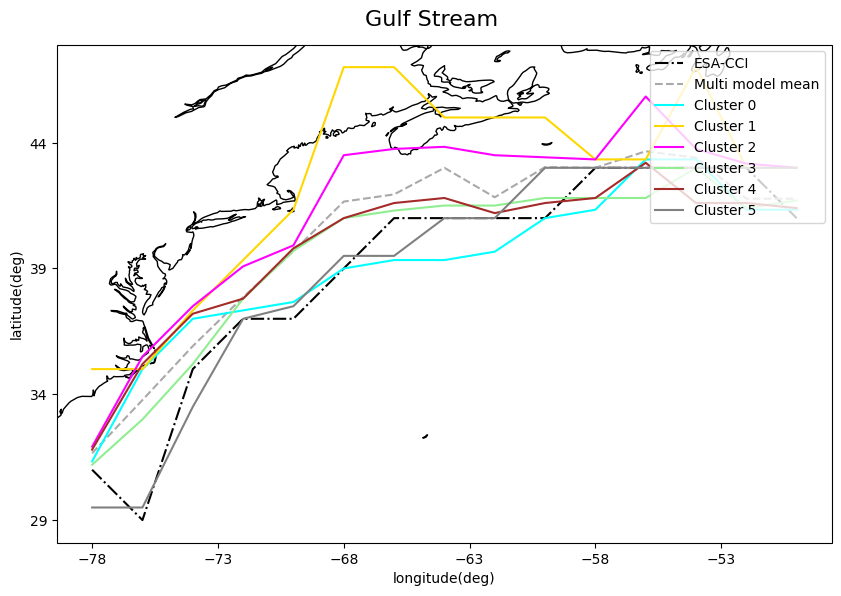

In [31]:
#Plot della Gulf Stream come i massimo del gradiente per ogni longitudine
lat = models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lat.values
lon = (models[list_4_clusters_new[0][0]]['GS box seas mean DJF'].lon.values - 360.)
color_list = ['black','darkgrey','cyan','gold','fuchsia','lightgreen','brown','grey'] #lista di colori perché voglio colori tutti diversi per le diverse Gulf Stream
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
ax.plot(index_max_value_esa_xr.lon - 360, index_max_value_esa_xr.data, color=color_list[0], linestyle='-.', transform=ccrs.PlateCarree(),label='ESA-CCI')
ax.plot(array_max_mean_all_models_xr.lon - 360, array_max_mean_all_models_xr.data, color=color_list[1], linestyle='--', transform=ccrs.PlateCarree(),label='Multi model mean')
for index in range(n_clusters):
    ax.plot(array_max_mean_xr[index].lon - 360, array_max_mean_xr[index].data, color=color_list[index+2], linestyle='-', transform=ccrs.PlateCarree(),label=f'Cluster {index}')
ax.coastlines()
ax.legend(loc='upper right')
ax.set_xlabel('longitude(deg)')
ax.set_ylabel('latitude(deg)') 
ax.set_xticks(np.arange(lon.min(), lon.max(), 5))
ax.set_yticks(np.arange(lat.min(), lat.max(), 5))
fig.suptitle('Gulf Stream', fontsize=16, y=0.85)